https://data.mendeley.com/datasets/34rczh25kc/4

In [1]:
#Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn for Preprocessing and Metrics 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix

# TensorFlow and Keras for Deep Learning Models 
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Input
from tensorflow.keras.callbacks import EarlyStopping
from collections import deque

# Notebook Settings 
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

print("Libraries imported successfully.")
print(f"TensorFlow Version: {tf.__version__}")

Libraries imported successfully.
TensorFlow Version: 2.20.0


In [2]:
# Load the dataset from the Excel file
file_path = 'data/Sensor_data_for_30_cm.xlsx'

df_raw = pd.read_excel(file_path)
print("Dataset loaded successfully.")
print("Shape of the raw dataset:", df_raw.shape)

# Display the first 5 rows
print("\nFirst 5 rows of the raw data:")
display(df_raw.head())

# Get a concise summary of the dataframe
print("\nDataset Info:")
df_raw.info()

Dataset loaded successfully.
Shape of the raw dataset: (9623, 4)

First 5 rows of the raw data:


,Date and Time,Temperature (°C),pH,Turbidity (NTU)
0,2020-01-15 16:00:35,20.99,7.81,197
1,2020-01-15 16:01:33,20.99,7.81,197
2,2020-01-15 16:02:33,20.98,7.81,197
3,2020-01-15 16:03:22,20.98,7.81,197
4,2020-01-15 16:04:26,20.98,7.81,197



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9623 entries, 0 to 9622
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date and Time      9623 non-null   object 
 1   Temperature (°C)   9623 non-null   float64
 2   pH                 9623 non-null   float64
 3   Turbidity (NTU)    9623 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 300.8+ KB


In [12]:
# Create a copy to preserve the original raw data
df = df_raw.copy()
# Rename columns for easier access
df.columns = ['datetime', 'temperature', 'ph', 'turbidity']
print(df.index)
display(df.head())

# Convert 'datetime' column to datetime objects
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.sort_index(inplace = True)

print("The new index is a DatetimeIndex:")
print(df.index)
print("\nThe 'datetime' values are now the row labels (the index):")
display(df.head())

# Feature Engineering: Add 'is_day' feature (1 for day, 0 for night)
df['is_day'] = np.where((df.index.hour >= 6) & (df.index.hour < 18), 1, 0)
print("4. 'is_day' feature created.")

# Feature Engineering: Add 'weather' feature ('dry' or 'rainy')
df['weather'] = 'dry'
# The description states rows 6149-7461 are rainy. In 0-based indexing, this is iloc[6148:7461].
df.iloc[6148:7461] = df.iloc[6148:7461].assign(weather='rainy')
print("5. 'weather' feature created.")

# Verification
print("\n--- Preprocessing Complete ---")
print("Shape of the processed dataset:", df.shape)
print("\nFirst 5 rows of the processed data:")
display(df.head())
print("\nLast 5 rows of the processed data:")
display(df.tail())
print("\nData types after processing:")
df.info()



RangeIndex(start=0, stop=9623, step=1)


,datetime,temperature,ph,turbidity
0,2020-01-15 16:00:35,20.99,7.81,197
1,2020-01-15 16:01:33,20.99,7.81,197
2,2020-01-15 16:02:33,20.98,7.81,197
3,2020-01-15 16:03:22,20.98,7.81,197
4,2020-01-15 16:04:26,20.98,7.81,197


The new index is a DatetimeIndex:
DatetimeIndex(['2020-01-15 16:00:35', '2020-01-15 16:01:33',
               '2020-01-15 16:02:33', '2020-01-15 16:03:22',
               '2020-01-15 16:04:26', '2020-01-15 16:05:21',
               '2020-01-15 16:06:20', '2020-01-15 16:07:17',
               '2020-01-15 16:08:59', '2020-01-15 16:10:00',
               ...
               '2020-01-22 16:11:02', '2020-01-22 16:16:31',
               '2020-01-22 16:17:39', '2020-01-22 16:18:46',
               '2020-01-22 16:19:53', '2020-01-22 16:21:01',
               '2020-01-22 16:22:09', '2020-01-22 16:23:16',
               '2020-01-22 16:24:23', '2020-01-22 16:25:32'],
              dtype='datetime64[ns]', name='datetime', length=9623, freq=None)

The 'datetime' values are now the row labels (the index):


,temperature,ph,turbidity
datetime,,,
2020-01-15 16:00:35,20.99,7.81,197
2020-01-15 16:01:33,20.99,7.81,197
2020-01-15 16:02:33,20.98,7.81,197
2020-01-15 16:03:22,20.98,7.81,197
2020-01-15 16:04:26,20.98,7.81,197


4. 'is_day' feature created.
5. 'weather' feature created.

--- Preprocessing Complete ---
Shape of the processed dataset: (9623, 5)

First 5 rows of the processed data:


,temperature,ph,turbidity,is_day,weather
datetime,,,,,
2020-01-15 16:00:35,20.99,7.81,197,1,dry
2020-01-15 16:01:33,20.99,7.81,197,1,dry
2020-01-15 16:02:33,20.98,7.81,197,1,dry
2020-01-15 16:03:22,20.98,7.81,197,1,dry
2020-01-15 16:04:26,20.98,7.81,197,1,dry



Last 5 rows of the processed data:


,temperature,ph,turbidity,is_day,weather
datetime,,,,,
2020-01-22 16:21:01,21.32,7.49,212,1,dry
2020-01-22 16:22:09,21.32,7.49,212,1,dry
2020-01-22 16:23:16,21.34,7.49,212,1,dry
2020-01-22 16:24:23,21.34,7.50,212,1,dry
2020-01-22 16:25:32,21.31,7.51,212,1,dry



Data types after processing:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9623 entries, 2020-01-15 16:00:35 to 2020-01-22 16:25:32
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  9623 non-null   float64
 1   ph           9623 non-null   float64
 2   turbidity    9623 non-null   int64  
 3   is_day       9623 non-null   int64  
 4   weather      9623 non-null   object 
dtypes: float64(2), int64(2), object(1)
memory usage: 451.1+ KB


In [ ]:
#Select features for the model
features_to_use = ['temperature', 'ph', 'turbidity', 'is_day']
target_to_predict = 'temperature'

# Create a new dataframe with the selected features
forecast_df = df[features_to_use].copy()
print("Selected features for forecasting:")
display(forecast_df.head())

#  Scale all features to a range between 0 and 1
scaler_forecast = MinMaxScaler()
scaled_data = scaler_forecast.fit_transform(forecast_df)
print("\nShape of scaled data:", scaled_data.shape)

# Create a function to generate sequences for direct 15-minute forecasting
def create_sequences_15min(data, n_steps_in, n_steps_out):
    X, y = [], []
    # Find the index of our target column before scaling
    target_col_index = forecast_df.columns.get_loc(target_to_predict)

    for i in range(len(data) - n_steps_in - (n_steps_out - 1)):
        # Input sequence (past n_steps_in)
        X.append(data[i : i + n_steps_in])
        # Output value (the temperature at n_steps_out in the future)
        y.append(data[i + n_steps_in + (n_steps_out - 1), target_col_index])
    return np.array(X), np.array(y)

# Parameters
N_STEPS_IN = 60     # Use the last 60 minutes of data (input)
N_STEPS_OUT = 15    # Predict the temperature 15 minutes ahead (output)

X_forecast, y_forecast = create_sequences_15min(scaled_data, N_STEPS_IN, N_STEPS_OUT)
print(f"\nCreated sequences using {N_STEPS_IN} steps to predict {N_STEPS_OUT} steps ahead.")
print("Shape of X:", X_forecast.shape)
print("Shape of y:", y_forecast.shape)

# Split data into training and testing sets (chronological split)
split_index = int(len(X_forecast) * 0.8)
X_train, X_test = X_forecast[:split_index], X_forecast[split_index:]
y_train, y_test = y_forecast[:split_index], y_forecast[split_index:]

print("\nData split into training and testing sets.")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

Selected features for forecasting:


,temperature,ph,turbidity,is_day
datetime,,,,
2020-01-15 16:00:35,20.99,7.81,197,1
2020-01-15 16:01:33,20.99,7.81,197,1
2020-01-15 16:02:33,20.98,7.81,197,1
2020-01-15 16:03:22,20.98,7.81,197,1
2020-01-15 16:04:26,20.98,7.81,197,1



Shape of scaled data: (9623, 4)

Created sequences using 60 steps to predict 15 steps ahead.
Shape of X: (9549, 60, 4)
Shape of y: (9549,)

Data split into training and testing sets.
X_train shape: (7639, 60, 4)
X_test shape: (1910, 60, 4)


In [ ]:
# Define the LSTM model architecture
model_forecast = Sequential([
    LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(units=1)
])

# Compile the model
model_forecast.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model_forecast.summary()

# Train the model
print("\n Training the Forecasting Model")
history = model_forecast.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

c:\Users\snn\AppData\Local\Schrodinger\PyMOL2\envs\bioaqws\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 50)             │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,051 (43.17 KB)

 Trainable params: 11,051 (43.17 KB)

 Non-trainable params: 0 (0.00 B)


--- Training the Forecasting Model ---
Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.0345 - val_loss: 0.0152
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0065 - val_loss: 0.0131
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0049 - val_loss: 0.0111
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0046 - val_loss: 0.0115
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0042 - val_loss: 0.0157
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0036 - val_loss: 0.0130


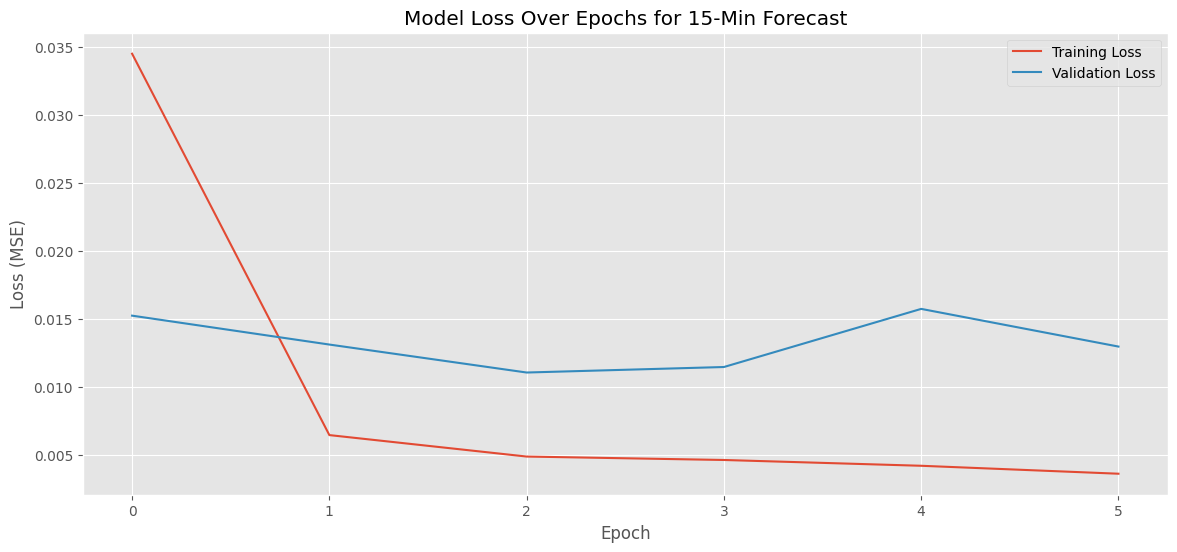

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


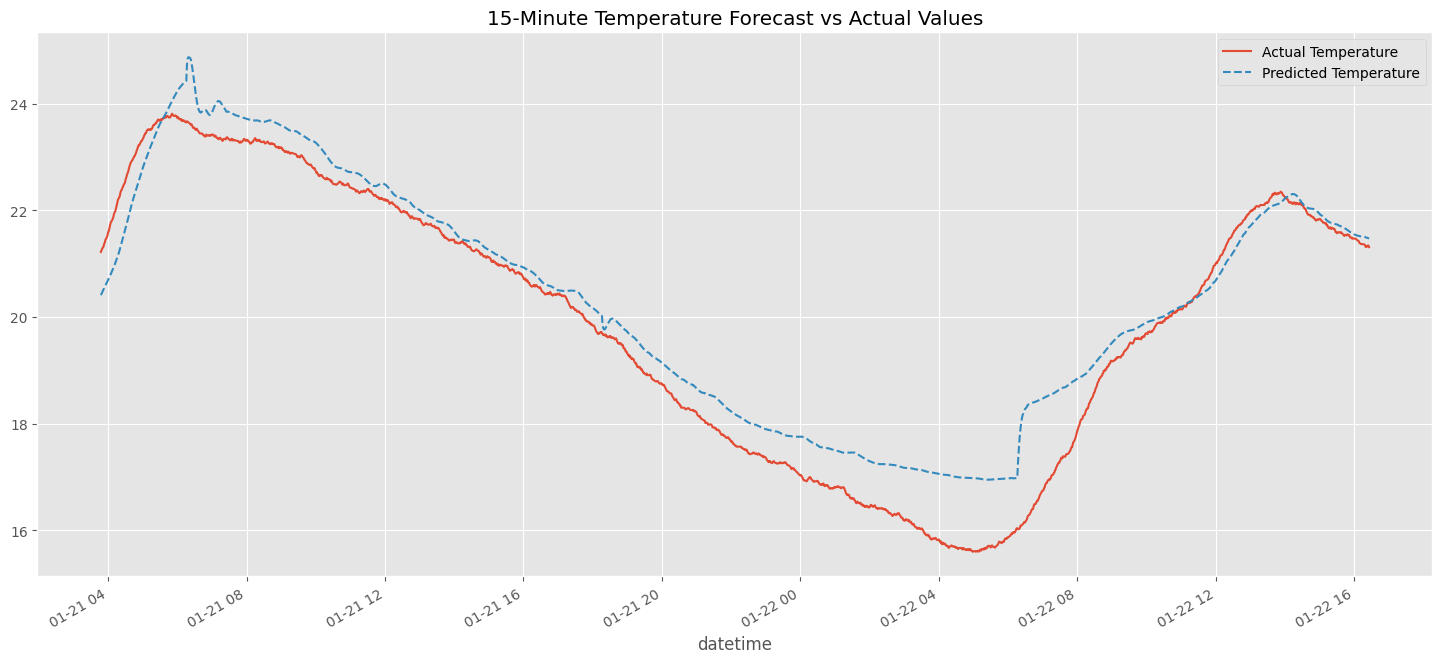

Mean Absolute Error (MAE) for 15-min forecast: 0.5180
Root Mean Squared Error (RMSE) for 15-min forecast: 0.6668


In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(14, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs for 15-Min Forecast')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Make predictions on the test set
y_pred_scaled = model_forecast.predict(X_test)

# To properly inverse transform, we need to create a dummy array with the same shape as the original scaled data
# The prediction is for 'temperature', which is the first column (index 0).
dummy_array = np.zeros((len(y_pred_scaled), forecast_df.shape[1]))
dummy_array[:, 0] = y_pred_scaled.ravel()

# Inverse transform the predictions using the correct scaler
y_pred = scaler_forecast.inverse_transform(dummy_array)[:, 0]

# Inverse transform the true values (y_test) as well for comparison
dummy_array_true = np.zeros((len(y_test), forecast_df.shape[1]))
dummy_array_true[:, 0] = y_test.ravel()
y_test_actual = scaler_forecast.inverse_transform(dummy_array_true)[:, 0]

# Visualization of Predictions vs Actuals
results_df = pd.DataFrame({
    'Actual Temperature': y_test_actual,
    'Predicted Temperature': y_pred
}, index=forecast_df.index[-len(y_test_actual):])

plt.figure(figsize=(18, 8))
results_df['Actual Temperature'].plot(label='Actual Temperature', style='-')
results_df['Predicted Temperature'].plot(label='Predicted Temperature', style='--')
plt.title('15-Minute Temperature Forecast vs Actual Values')
plt.legend()
plt.show()

# Quantitative Evaluation 
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
print(f"Mean Absolute Error (MAE) for 15-min forecast: {mae:.4f}")
print(f"Root Mean Squared Error (RMSE) for 15-min forecast: {rmse:.4f}")

## Anomaly Detection

In [ ]:
# Select the feature for anomaly detection
anomaly_df = df[['turbidity']].copy()

# Scale the data
scaler_anomaly = MinMaxScaler()
anomaly_df['turbidity_scaled'] = scaler_anomaly.fit_transform(anomaly_df)
display(anomaly_df.head())

# Create training data from the "normal" period (dry weather)
train_anomaly_df = anomaly_df[df['weather'] == 'dry']
train_anomaly_data = train_anomaly_df['turbidity_scaled'].values.reshape(-1, 1)

print("Shape of normal (training) data:", train_anomaly_data.shape)

# Create sequences for the autoencoder
# For autoencoders, the input (X) and output (y) are the same sequence
def create_anomaly_sequences(data, n_steps):
    X = []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
    return np.array(X)

N_STEPS_ANOMALY = 30 # Using a 30-minute window to define a pattern

X_train_anomaly = create_anomaly_sequences(train_anomaly_data, N_STEPS_ANOMALY)
print("\nShape of anomaly training sequences (X):", X_train_anomaly.shape)

,turbidity,turbidity_scaled
datetime,,
2020-01-15 16:00:35,197,0.054545
2020-01-15 16:01:33,197,0.054545
2020-01-15 16:02:33,197,0.054545
2020-01-15 16:03:22,197,0.054545
2020-01-15 16:04:26,197,0.054545


Shape of normal (training) data: (8310, 1)

Shape of anomaly training sequences (X): (8280, 30, 1)


In [ ]:
# Define the LSTM Autoencoder architecture
model_anomaly = Sequential([
    # Encoder
    LSTM(units=64, activation='relu', input_shape=(X_train_anomaly.shape[1], X_train_anomaly.shape[2])),
    RepeatVector(X_train_anomaly.shape[1]),
    # Decoder
    LSTM(units=64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(units=1))
])

model_anomaly.compile(optimizer='adam', loss='mae')
model_anomaly.summary()

# Train the model on "normal" data only
print("\nTraining the Anomaly Detection Model")
history_anomaly = model_anomaly.fit(
    X_train_anomaly, X_train_anomaly, # Note: X and y are the same
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

c:\Users\snn\AppData\Local\Schrodinger\PyMOL2\envs\bioaqws\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 30, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)


--- Training the Anomaly Detection Model ---
Epoch 1/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 0.0431 - val_loss: 0.0194
Epoch 2/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0108 - val_loss: 0.0142
Epoch 3/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0081 - val_loss: 0.0058
Epoch 4/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0074 - val_loss: 0.0083
Epoch 5/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0069 - val_loss: 0.0036
Epoch 6/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0067 - val_loss: 0.0059
Epoch 7/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0065 - val_loss: 0.0102
Epoch 8/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0072 - val_loss: 0.0033
Epoch 9/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 10/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0075 - val_loss: 0.0032


259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Anomaly Threshold set to the 99th percentile: 0.0144
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Number of anomalies detected: 517


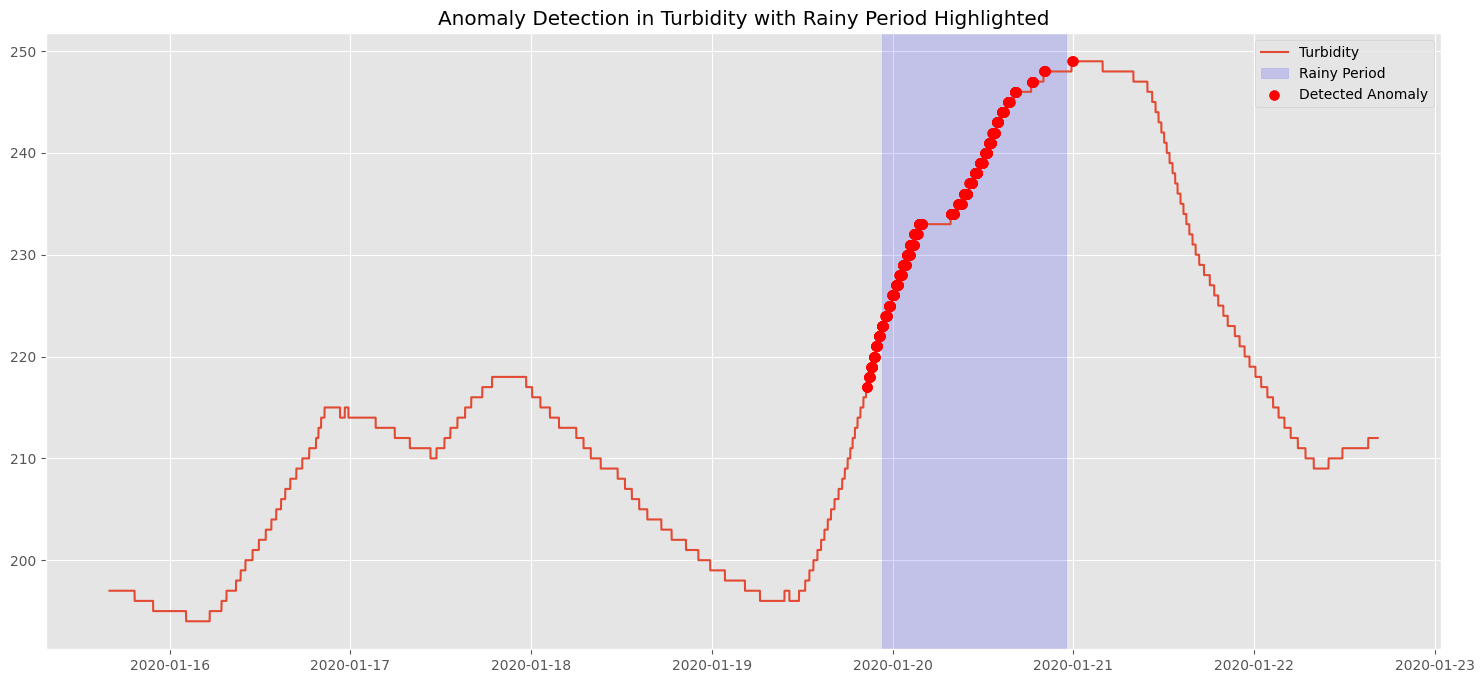

In [ ]:
# Calculate reconstruction loss on the training data to find a threshold
X_train_pred = model_anomaly.predict(X_train_anomaly)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train_anomaly), axis=1).flatten()

# more robust than using the maximum value, as it's less sensitive to
# single outliers within the training data itself.
threshold = np.quantile(train_mae_loss, 0.99)
print(f"Anomaly Threshold set to the 99th percentile: {threshold:.4f}")

#Calculate reconstruction loss on the ENTIRE dataset
all_data_scaled = anomaly_df['turbidity_scaled'].values.reshape(-1, 1)
X_all = create_anomaly_sequences(all_data_scaled, N_STEPS_ANOMALY)
all_pred = model_anomaly.predict(X_all)
all_mae_loss = np.mean(np.abs(all_pred - X_all), axis=1).flatten()

# Identify anomalies
anomaly_indices = np.where(all_mae_loss > threshold)[0]
print(f"Number of anomalies detected: {len(anomaly_indices)}")

# Create an anomaly dataframe for plotting
anomalies = pd.DataFrame(index=anomaly_df.index, columns=['turbidity'])
for idx in anomaly_indices:
    # Mark the end of the anomalous sequence
    sequence_end_index = idx + N_STEPS_ANOMALY - 1
    if sequence_end_index < len(anomalies):
        anomalies.iloc[sequence_end_index] = anomaly_df['turbidity'].iloc[sequence_end_index]

# Enhanced Visualization with Rainy Period Highlighted ---
plt.figure(figsize=(18, 8))

# Plot the main turbidity time series
plt.plot(anomaly_df.index, anomaly_df['turbidity'], label='Turbidity', zorder=2)

# Find the start and end of the rainy period
rainy_period = df[df['weather'] == 'rainy']
rainy_start = rainy_period.index.min()
rainy_end = rainy_period.index.max()

# Highlight the rainy period on the graph
plt.axvspan(rainy_start, rainy_end, color='blue', alpha=0.15, label='Rainy Period', zorder=1)

# Plot the detected anomalies
plt.scatter(anomalies.index, anomalies['turbidity'], color='red', label='Detected Anomaly', s=50, zorder=3)

plt.title('Anomaly Detection in Turbidity with Rainy Period Highlighted')
plt.legend()
plt.show()

In [ ]:
# Real-time Anomaly Detection Simulation with Stateful Alarm Logic
# Setup

transition_point = df[df['weather'] == 'rainy'].index.min()
transition_index = df.index.get_loc(transition_point)

start_index = transition_index - 300
end_index = transition_index + 300
print(f"Simulation will run from {df.index[start_index]} to {df.index[end_index]}")

# State Variables for the Alarm System
# Stores timestamps of recent anomalies within the last 5 minutes
recent_anomalies = deque() 
ALARM_STATE = False # Is the main, persistent alarm ON or OFF?
normal_streak_counter = 0 # Counts consecutive minutes the system is "normal"

# Parameters for the alarm logic
MINUTES_WINDOW_FOR_TRIGGER = 15 # Check for anomalies within this window (in minutes)
ANOMALY_COUNT_TO_TRIGGER = 5   # Number of anomalies in the window to trigger the alarm
MINUTES_STREAK_TO_RESET = 60    # Consecutive normal minutes required to turn off the alarm

# Store simulation results
simulation_results = []
first_alarm_time = None

# The Simulation Loop
for current_step in range(start_index, end_index):
    if current_step - N_STEPS_ANOMALY < 0: continue
        
    current_time = df.index[current_step - 1]
    
    # Get window, reshape, predict, and calculate error
    window = all_data_scaled[current_step - N_STEPS_ANOMALY : current_step]
    window_reshaped = window.reshape(1, N_STEPS_ANOMALY, 1)
    reconstruction = model_anomaly.predict(window_reshaped, verbose=0)
    error = np.mean(np.abs(reconstruction - window_reshaped))
    
    is_anomaly_now = error > threshold
    
    # Stateful Alarm Logic
    # 2a. Update recent anomalies list (keep it to the last 5 minutes)
    while recent_anomalies and (current_time - recent_anomalies[0]).total_seconds() / 60 > MINUTES_WINDOW_FOR_TRIGGER:
        recent_anomalies.popleft()
    if is_anomaly_now:
        recent_anomalies.append(current_time)

    # 2b. Check if the alarm should be TRIGGERED
    if not ALARM_STATE and len(recent_anomalies) >= ANOMALY_COUNT_TO_TRIGGER:
        ALARM_STATE = True
        if first_alarm_time is None: first_alarm_time = current_time
        normal_streak_counter = 0 # Reset counter when alarm triggers

    # 2c. Check if the alarm should be RESET
    if ALARM_STATE:
        if not is_anomaly_now:
            normal_streak_counter += 1
        else:
            normal_streak_counter = 0 # Any new anomaly breaks the "normal" streak
            
        if normal_streak_counter >= MINUTES_STREAK_TO_RESET:
            ALARM_STATE = False
            normal_streak_counter = 0 # Reset counter after turning off alarm
            
    # Get actual turbidity and print status
    actual_turbidity = scaler_anomaly.inverse_transform([[all_data_scaled[current_step-1][0]]])[0][0]
    status_text = "PERSISTENT ALARM" if ALARM_STATE else "System Normal"
    print(f"Time: {current_time} | Turbidity: {actual_turbidity:.2f} | Error: {error:.4f} | Status: {status_text}")
    
    simulation_results.append([current_time, actual_turbidity, error, ALARM_STATE])

# 3. Create DataFrame and show summary
results_sim_df = pd.DataFrame(simulation_results, columns=['datetime', 'turbidity', 'error', 'alarm_on'])
results_sim_df.set_index('datetime', inplace=True)
print(f"\nSimulation Complete. First alarm triggered at: {first_alarm_time}")

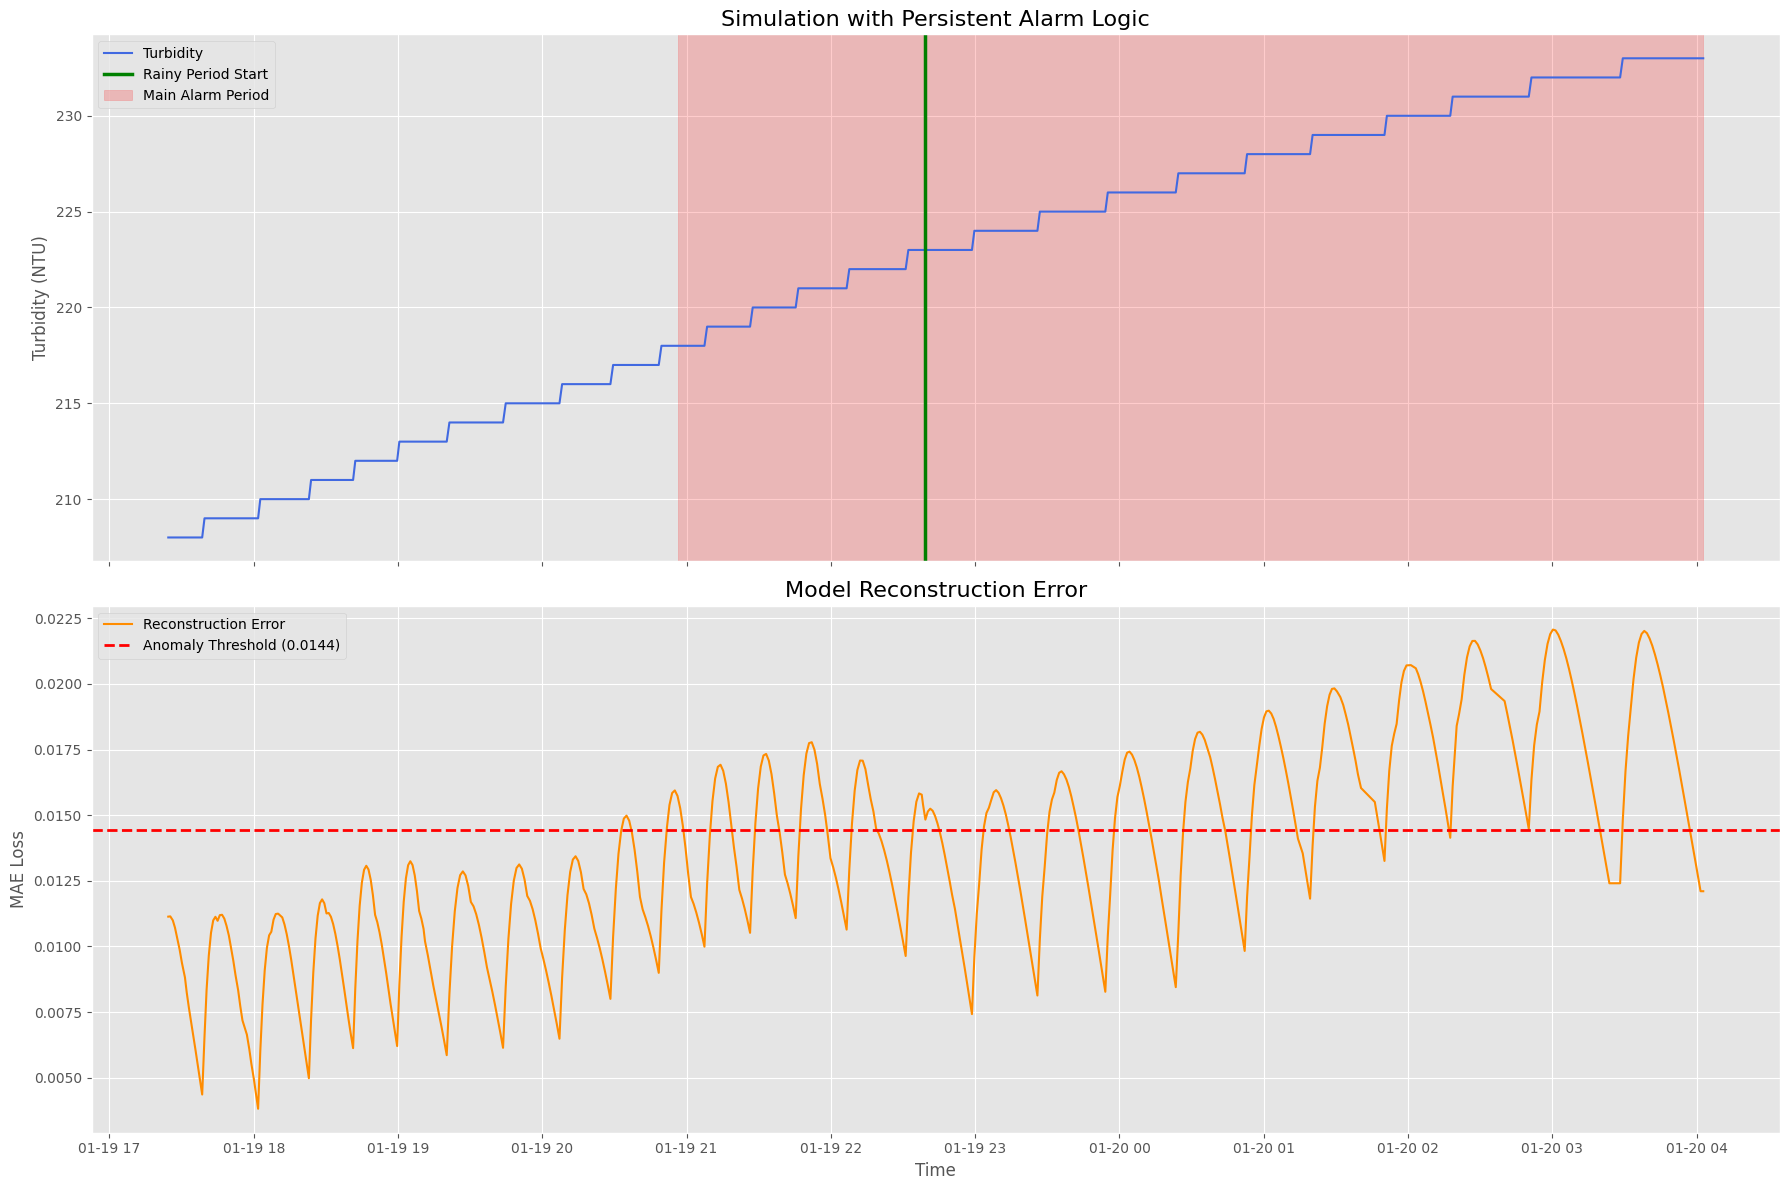

In [ ]:
# Visualize the persistent alarm state over time with Rain Start marker

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12), sharex=True)

# Top Plot: Turbidity, Rain Start, and Alarm Periods 
ax1.plot(results_sim_df.index, results_sim_df['turbidity'], label='Turbidity', color='royalblue')
ax1.set_title('Simulation with Persistent Alarm Logic', fontsize=16)
ax1.set_ylabel('Turbidity (NTU)')
ax1.grid(True)

# Add a vertical line to mark the exact start of the rainy period 
# The 'transition_point' variable was calculated in the previous cell.
if 'transition_point' in locals():
    ax1.axvline(x=transition_point, color='green', linestyle='-', linewidth=2.5, label=f'Rainy Period Start')

# Find periods where the alarm is ON and highlight them
alarm_periods = results_sim_df[results_sim_df['alarm_on']]
in_alarm_block = False
for index, row in results_sim_df.iterrows():
    if row['alarm_on'] and not in_alarm_block:
        alarm_start = index
        in_alarm_block = True
    elif not row['alarm_on'] and in_alarm_block:
        alarm_end = index
        in_alarm_block = False
        ax1.axvspan(alarm_start, alarm_end, color='red', alpha=0.2, label='_nolegend_')

# Handle case where alarm is on until the end of simulation
if in_alarm_block:
    ax1.axvspan(alarm_start, results_sim_df.index[-1], color='red', alpha=0.2, label='_nolegend_')

# Create a single legend entry for the alarm periods
if not alarm_periods.empty:
    ax1.fill_between([], [], [], color='red', alpha=0.2, label='Main Alarm Period')

ax1.legend()

#  Bottom Plot: Reconstruction Error vs. Threshold
ax2.plot(results_sim_df.index, results_sim_df['error'], label='Reconstruction Error', color='darkorange')
ax2.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'Anomaly Threshold ({threshold:.4f})')
ax2.set_title('Model Reconstruction Error', fontsize=16)
ax2.set_ylabel('MAE Loss')
ax2.set_xlabel('Time')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

## ALL data

In [ ]:
# --- Real-time Anomaly Detection Simulation with Stateful Alarm Logic ---

# Setup
#transition_point = df[df['weather'] == 'rainy'].index.min()
#transition_index = df.index.get_loc(transition_point)
#start_index = transition_index - 300
#end_index = transition_index + 300
#print(f"Simulation will run from {df.index[start_index]} to {df.index[end_index]}")

#
# The simulation must start after the first full window can be formed.
start_index = N_STEPS_ANOMALY
# The simulation will run until the end of the dataset.
end_index = len(df)
print(f"Simulation will run from {start_index} to {end_index}")

#  State Variables for the Alarm System 
# Stores timestamps of recent anomalies within the last 5 minutes
recent_anomalies = deque() 
ALARM_STATE = False # Is the main, persistent alarm ON or OFF?
normal_streak_counter = 0 # Counts consecutive minutes the system is "normal"

# Parameters for the alarm logic
MINUTES_WINDOW_FOR_TRIGGER = 15 # Check for anomalies within this window (in minutes)
ANOMALY_COUNT_TO_TRIGGER = 5   # Number of anomalies in the window to trigger the alarm
MINUTES_STREAK_TO_RESET = 60    # Consecutive normal minutes required to turn off the alarm

# Store simulation results
simulation_results = []
first_alarm_time = None

# The Simulation Loop
for current_step in range(start_index, end_index):
    if current_step - N_STEPS_ANOMALY < 0: continue
        
    current_time = df.index[current_step - 1]
    
    # Get window, reshape, predict, and calculate error
    window = all_data_scaled[current_step - N_STEPS_ANOMALY : current_step]
    window_reshaped = window.reshape(1, N_STEPS_ANOMALY, 1)
    reconstruction = model_anomaly.predict(window_reshaped, verbose=0)
    error = np.mean(np.abs(reconstruction - window_reshaped))
    
    is_anomaly_now = error > threshold
    
    
    # 2a. Update recent anomalies list (keep it to the last 5 minutes)
    while recent_anomalies and (current_time - recent_anomalies[0]).total_seconds() / 60 > MINUTES_WINDOW_FOR_TRIGGER:
        recent_anomalies.popleft()
    if is_anomaly_now:
        recent_anomalies.append(current_time)

    # 2b. Check if the alarm should be TRIGGERED
    if not ALARM_STATE and len(recent_anomalies) >= ANOMALY_COUNT_TO_TRIGGER:
        ALARM_STATE = True
        if first_alarm_time is None: first_alarm_time = current_time
        normal_streak_counter = 0 # Reset counter when alarm triggers

    # 2c. Check if the alarm should be RESET
    if ALARM_STATE:
        if not is_anomaly_now:
            normal_streak_counter += 1
        else:
            normal_streak_counter = 0 # Any new anomaly breaks the "normal" streak
            
        if normal_streak_counter >= MINUTES_STREAK_TO_RESET:
            ALARM_STATE = False
            normal_streak_counter = 0 # Reset counter after turning off alarm
            
    # Get actual turbidity and print status
    actual_turbidity = scaler_anomaly.inverse_transform([[all_data_scaled[current_step-1][0]]])[0][0]
    status_text = "PERSISTENT ALARM" if ALARM_STATE else "System Normal"
    print(f"Time: {current_time} | Turbidity: {actual_turbidity:.2f} | Error: {error:.4f} | Status: {status_text}")
    
    simulation_results.append([current_time, actual_turbidity, error, ALARM_STATE])

#Create DataFrame and show summary
results_sim_df = pd.DataFrame(simulation_results, columns=['datetime', 'turbidity', 'error', 'alarm_on'])
results_sim_df.set_index('datetime', inplace=True)
print(f"\nSimulation Complete. First alarm triggered at: {first_alarm_time}")

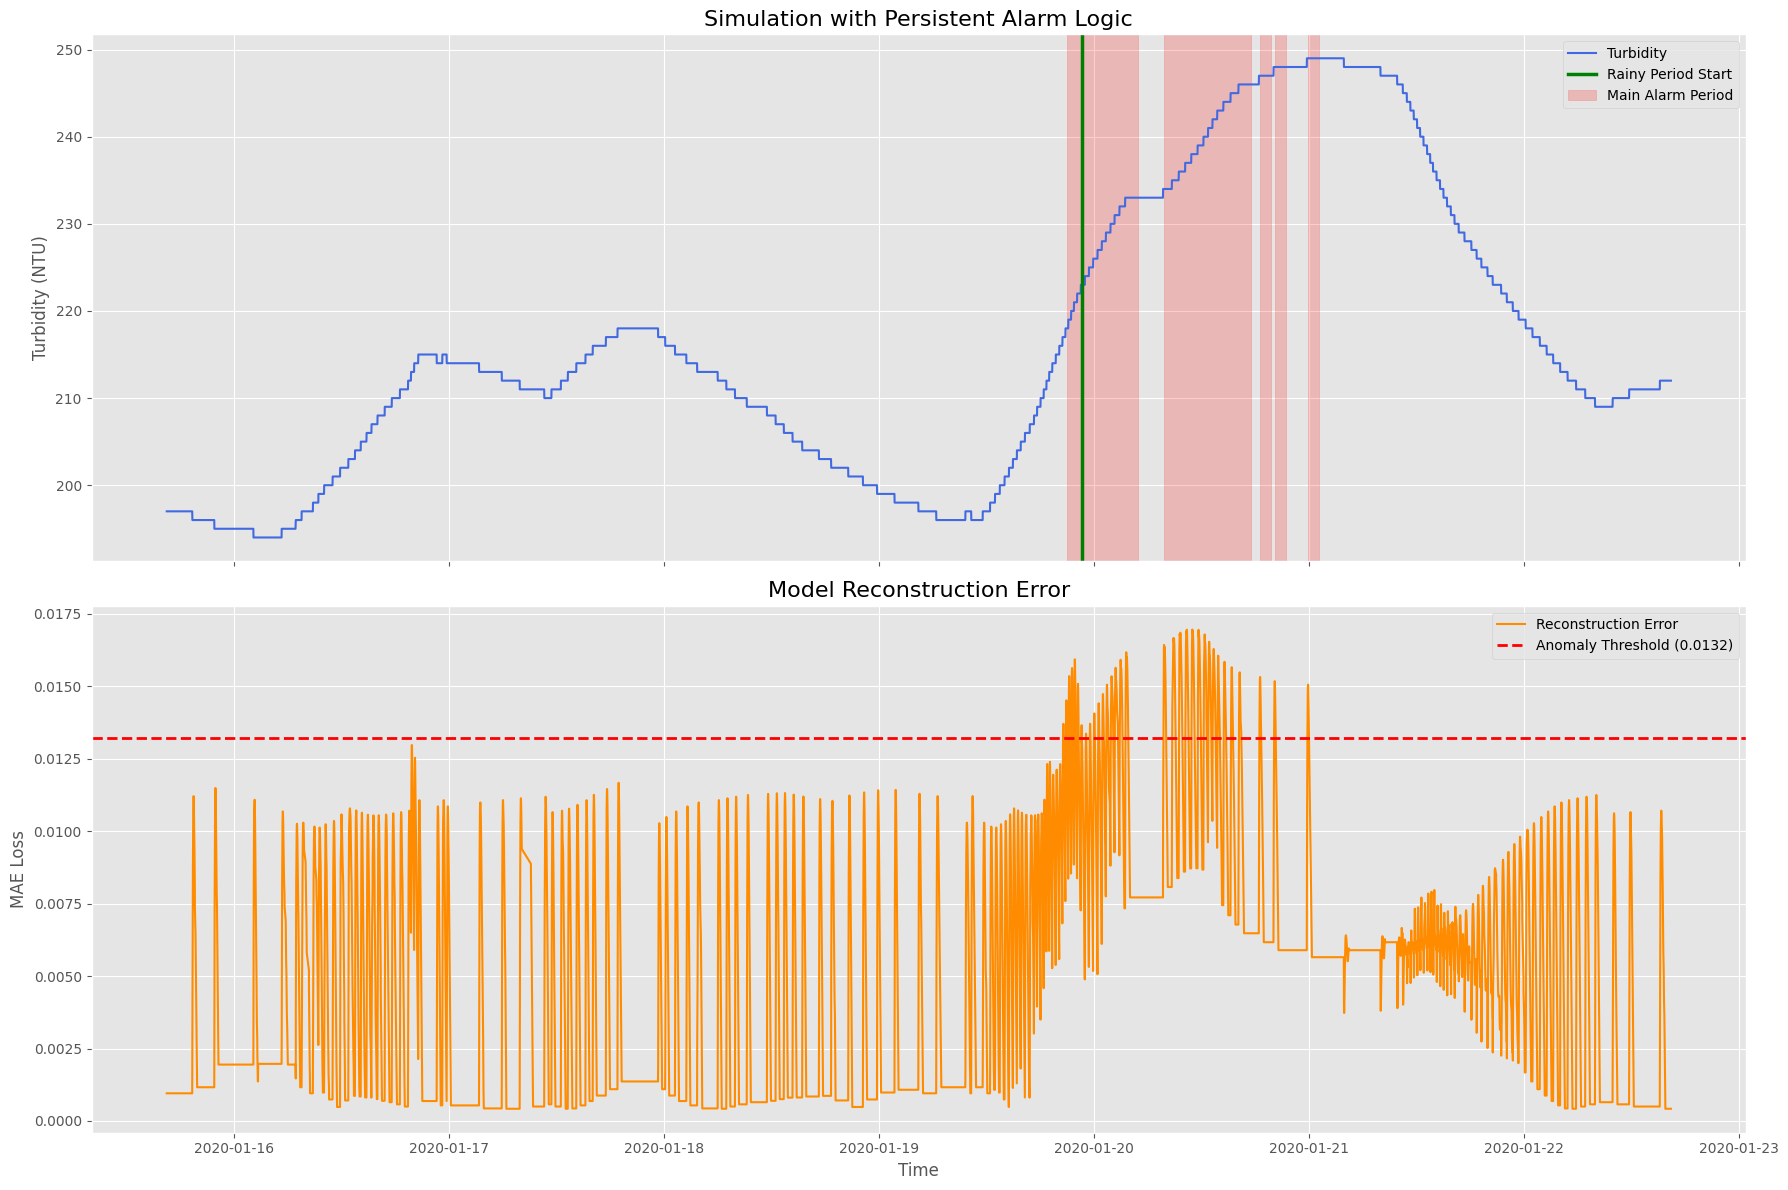

In [ ]:
#Visualize the persistent alarm state over time with Rain Start marker 

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12), sharex=True)

# Top Plot: Turbidity, Rain Start, and Alarm Period
ax1.plot(results_sim_df.index, results_sim_df['turbidity'], label='Turbidity', color='royalblue')
ax1.set_title('Simulation with Persistent Alarm Logic', fontsize=16)
ax1.set_ylabel('Turbidity (NTU)')
ax1.grid(True)

# Add a vertical line to mark the exact start of the rainy period 
# The 'transition_point' variable was calculated in the previous cell.
if 'transition_point' in locals():
    ax1.axvline(x=transition_point, color='green', linestyle='-', linewidth=2.5, label=f'Rainy Period Start')

# Find periods where the alarm is ON and highlight them
alarm_periods = results_sim_df[results_sim_df['alarm_on']]
in_alarm_block = False
for index, row in results_sim_df.iterrows():
    if row['alarm_on'] and not in_alarm_block:
        alarm_start = index
        in_alarm_block = True
    elif not row['alarm_on'] and in_alarm_block:
        alarm_end = index
        in_alarm_block = False
        ax1.axvspan(alarm_start, alarm_end, color='red', alpha=0.2, label='_nolegend_')

# Handle case where alarm is on until the end of simulation
if in_alarm_block:
    ax1.axvspan(alarm_start, results_sim_df.index[-1], color='red', alpha=0.2, label='_nolegend_')

# Create a single legend entry for the alarm periods
if not alarm_periods.empty:
    ax1.fill_between([], [], [], color='red', alpha=0.2, label='Main Alarm Period')

ax1.legend()

#  Bottom Plot: Reconstruction Error vs. Threshold 
ax2.plot(results_sim_df.index, results_sim_df['error'], label='Reconstruction Error', color='darkorange')
ax2.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'Anomaly Threshold ({threshold:.4f})')
ax2.set_title('Model Reconstruction Error', fontsize=16)
ax2.set_ylabel('MAE Loss')
ax2.set_xlabel('Time')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()